# H<sub>2</sub>Powerlaw

This notebook walks through our Python adaptation of the molecular hydrogen (H<sub>2</sub>) excitation model presented in Togi & Smith (2016, hereafter TS16). We use H<sub>2</sub> line fluxes for the galaxy NGC 5033 as an example of this code's ability to reproduce the power-law slopes and cutoff temperatures given in TS16, as well as the inferred H<sub>2</sub> mass.

1. [Imports and defining constants](#Imports)
2. [Example use](#Example)
    1. [NGC 5033](#NGC5033)
       1. [Excitation fits](#Excitations)
       2. [H<sub>2</sub> Masses](#Masses)
       3. [Plotting PL Fits](#Plotting)

##  Imports and defining constants <a name="Imports"></a>

This notebook, and ``H2Powerlaw`` generally, use the following packages:

* **numpy** and **scipy** for handling array functions, including fitting
* **astropy** for unit manipulation
* **matplotlib** for data visualization 

If you do not have these packages installed, you can install them using pip or conda. For interactive plotting, we additionally recommend installing **ipympl** and running the cell containing ``%matplotlib widget`` below.

In [1]:
# %matplotlib widget

In [2]:
## Array and unit maniuplation
import numpy as np
import astropy.units as u

## Visualization
import matplotlib.pyplot as plt

## The temperature/excitation model
from H2Powerlaw import H2Model

## Example use <a name="Example"></a>

### NGC 5033 <a name="NGC5033"></a>

The next several cells illustrate how to use the TS16 model to compute the power-law slope, cutoff temperature
T<sub>l</sub>, and H<sub>2</sub> mass using real H<sub>2</sub> line measurements for the galaxy NGC 5033 (see TS16 Table 2 and references therein).

#### Excitation fits <a name="Excitations"></a>

First, let's create an `H2Model` object with just the required arguments - flux, flux uncertainties, and $J_{lower}$ values for the transitions. The resulting object `p1` has these properties plus:
* a parameter `j_norm`, which defines the transition to which all other fluxes and column densities N<sub>j</sub> are normalized. By default, `j_norm` = 1;
* a unit specifier f_unit, to keep track of unit conversions. By default, fluxes are assumed to be in SI units, W/m^2.

We can also look at the column density ratios through a call to `obs_ratio()`, which pulls fluxes from `p1`. The only required input is a list/array of *J* values, which can be the entire set assigned to `p1` (`p1.j_obs`) or some subset (e.g., `[0, 1, 3]`). Other properties are either set to `None` or are assigned dummy values (like the power-law slope `slope`) by default.

`obs_ratio()` returns the column densities for each transition population relative to `j_norm`, plus an array telling you which transitions you just used (just in case you need to keep track like I did during testing!). For direct comparison to modeled ratios, be sure to take their natural log.

In [3]:
# The minimal H2Model object for NGC 5033
p1 = H2Model(flux =  1e-17 * np.array([3.66, 18.20, 06.35, 12.69]),
            flux_err = 1e-17 * np.array( [0.35, 1.04, 0.31,1.91] ),
            j_obs = [0,1,2,3]
            )

# Create and print column density ratios using all lines assigned to p1
norm_ratios, norm_rat_j = p1.obs_ratio(p1.j_obs)
print("Column dens. ratios relative to J = 1, plus included transitions: \n", norm_ratios, norm_rat_j)

print("Natl. log of ratios relative to J = 1: \n", np.log(norm_ratios))

Column dens. ratios relative to J = 1, plus included transitions: 
 [2.25758134e+01 1.00000000e+00 1.01572056e-01 1.22274582e-02] ['S0' 'S1' 'S2' 'S3']
Natl. log of ratios relative to J = 1: 
 [ 3.11687913  0.         -2.28698682 -4.40407118]


Similarly, the normalized flux uncertainties can be examined through a call to `obs_flux_uncert()`. These do not need to be `np.log()`'d. 

In [4]:
norm_errs, norm_err_j = p1.obs_flux_uncert(p1.j_obs)
norm_errs, norm_err_j

(array([0.11140063, 0.0808122 , 0.07515711, 0.16099451]),
 array(['S0', 'S1', 'S2', 'S3'], dtype='<U2'))

Normalized ratios and flux uncertainties are all you really need to create a power-law H<sub>2</sub> model fit, but first we'll look at how to create those models by themselves.

We can simulate some column density ratios in the TS16 framework through a call to `nratio_model()`, again using the default `j_norm` = 1. Required inputs are a list of *J* values, a slope $n$, and a lower temperature cutoff $T_l$.

Because `nratio_model()` is a class method, it can be called either through a specific `H2Model` object (here `p1`) or directly from the `H2Model` class itself.

In [5]:
# Two ways to create normalized column densities from the power-law mode
n_model = p1.nratio_model(p1.j_obs, n = 5.0, Tl = 101.)
n_model_ = H2Model.nratio_model(p1.j_obs, n = 5.0, Tl = 101.)

print("Two ways of creating model column density ratios for warm H2: \n", n_model, "\n", n_model_)

# The same PL slope, but a different temperature cutoff
n_model = p1.nratio_model(p1.j_obs, n = 5.0, Tl = 51.)

print("Same PL slope, now including colder H2 gas: \n", n_model)

Two ways of creating model column density ratios for warm H2: 
 [ 2.88533869  0.         -2.46527714 -4.44162214] 
 [ 2.88533869  0.         -2.46527714 -4.44162214]
Same PL slope, now including colder H2 gas: 
 [ 3.40619737  0.         -2.49379078 -4.47037503]


To perform a Pl model fit, you don't *have* to explicitly use `obs_ratio()`, `obs_flux_uncert()`, or `nratio_model()` beforehand - all of these are called upon when running the fit. You can also print the observed and modeled column density ratios by setting `verbose = True`.

`do_fit()` yields a tuple of best-fit parameters `(slope, Tl)` and a tuple of uncertainties on those parameters `(slope_err, Tl_err)`. If setting `overwrite = True`, the respective properties of `p1` will be assigned these values (e.g., `param[0] -> p1.slope`).

We note that, while not identical to the power-law slope reported in TS16 for this target ($n$ = 4.72 here vs. 4.65 in TS16), it is very close and consistent within uncertainties. The uncertainty on $n$ inferred by this Python package may be slightly higher than in the original, IDL code, which we attribute to differences in the minimization algorithm.

In [6]:
param, unc = p1.do_fit(p1.j_obs, overwrite = True, verbose = True)

Modeling column density ratios for  J_lower = [0 1 2 3]
Nat. log of observed column density ratios, normalized to J = 1 :
[ 3.11687913  0.         -2.28698682 -4.40407118]
Nat. log of model column density ratios, normalized to J = 1 :
[ 3.11587422  0.         -2.35532338 -4.22723604]


In [7]:
print('Best-fit slope and Tl:', param)
print('Error on best-fit slope and Tl:', unc)

Best-fit slope and Tl: [ 4.72501703 69.07622869]
Error on best-fit slope and Tl: [ 0.11942461 16.35351594]


#### H<sub>2</sub> Masses <a name="Mass"></a>

The steps above simply constrain how excited the H<sub>2</sub> gas is through the power-law slope. You can go a step further and estimate the mass of H<sub>2</sub> warmer than some cutoff temperature, but first we have to set some additional parameters. (`p1.name` will come in handy in the [Plotting](#Plotting) section).

In [8]:
p1.omega = 1 * u.arcsec**2
p1.distance = 14.8 * u.Mpc
p1.name = "NGC 5033"

We can compute either a total column density of H<sub>2</sub> gas $N_{tot}(T > T_l')$ or the equivalent mass $M(T>T_l')$. The former is sensitive to what you define as the beam size of your observations; for *JWST*, for example, this could be the PSF FWHM of MIRI/MRS at some wavelength.

In [9]:
# The total H2 column density above our best-fit Tl
col = p1.total_column(p1.j_obs, 1, p1.slope, p1.Tl)
print("log(N_H2) =", np.log10(col))

# The equivalent mass in MSun
m = p1.calc_mass(p1.j_obs, 1, p1.slope, p1.Tl, p1.distance)
m

log(N_H2) = 13.292333278122351


<Quantity 68263723.36914304 solMass>

Whether you want the total H<sub>2</sub> column or mass, we remind the user that this is the amount of gas above some temperature $T_l'$, which can be different from the best-fit value of $T_l$ inferred above. If you're only interested in the warm (possibly shocked) H<sub>2</sub> gas, or want to extrapolate to colder temperatures to probe fainter, low-excitation gas, try experimenting with other values of $T_l'$.

This is also the stage at which we recommend varying the values of $n$ (or other sources of uncertainty like distance $D$) to get a handle on the mass uncertainties. Below we show the uncertainties on the H<sub>2</sub> mass assuming the best-fit $T_l$ but letting $n$ vary by its $1\sigma$ uncertainty.

In [10]:
print("For n = " + str(round(p1.slope, 3)) + ", T = 200")
p1.calc_mass(p1.j_obs, 1, p1.slope, 200., p1.distance, verbose = True) # Only the warmest gas

print("For n = " + str(round(p1.slope, 3)) + ", T = 50")
p1.calc_mass(p1.j_obs, 1, p1.slope, 50., p1.distance, verbose = True) # Extrapolating to lower temperatures

print("\n For n +/- 1sig, T = "+ str(round(p1.Tl, 1))) # Errors on H2 mass from only H2 slope uncertainties

for n in [p1.slope - p1.slope_err, p1.slope + p1.slope_err]:
    m_ = p1.calc_mass(p1.j_obs, 1, n, p1.Tl, p1.distance)
    print( round((m_ - m).value / 1e7, 3), "x1e7 Msun")

For n = 4.725, T = 200
The total mass of H2 between 200.0 and 2000.0 K is 2055735.8 Msun
For n = 4.725, T = 50
The total mass of H2 between 50.0 and 2000.0 K is 227354702.8 Msun

 For n +/- 1sig, T = 69.1
-0.768 x1e7 Msun
0.847 x1e7 Msun


#### Plotting PL fits <a name="Plotting"></a>

`H2Powerlaw` comes with a few convenient functions for generating basic H<sub>2</sub> excitation plots for the observed line fluxes and for some power-law model. These methods currently do not accept error bars as input; this is a priority in future development. All the formatting/aesthetic keywords you normally pass to `matplotlib.pyplot.plot()` can be input here.

Below, we plot both the observed column density ratios and the model ratios for the best-fit power-law. Just for fun, we'll also draw an excitation curve with a similar $T_l$ but a much steeper slope.

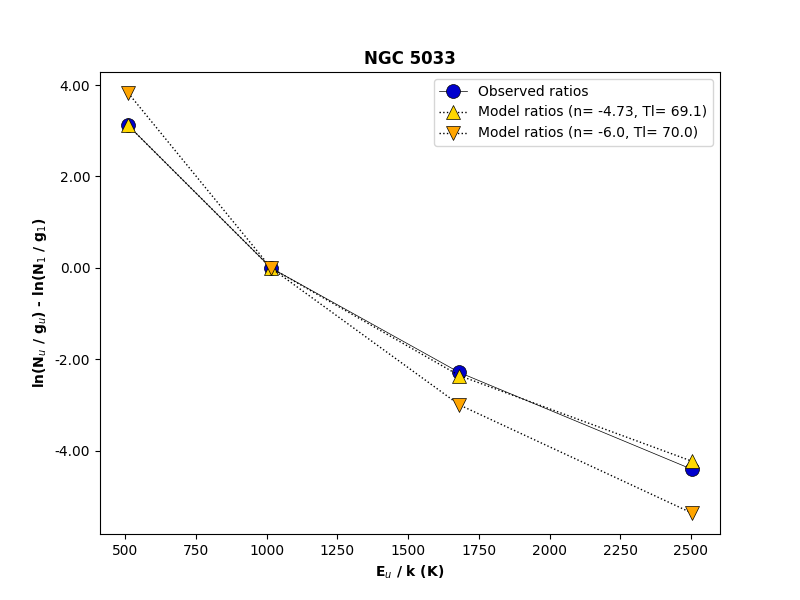

In [11]:
fig, ax = plt.subplots(figsize = (8,6))

p1.plot_obs_ratios(p1.j_obs, norm_ratios, ax = ax,
                   color = 'black', lw = 0.5, mfc = 'mediumblue', mec = 'black', mew = 0.5, ms = 10, marker = "o",  )
p1.plot_mod_ratios(p1.j_obs, p1.slope, p1.Tl, ax = ax, 
                   color = 'black', lw = 1, ls = ":", mfc = 'gold', mec = 'black', mew = 0.5, ms = 10, marker = "^", )

p1.plot_mod_ratios(p1.j_obs, 6.0, 70., ax = ax,
                   color = 'black', lw = 1, ls = ":", mfc = 'orange', mec = 'black', mew = 0.5, ms = 10, marker = "v", )

# plt.savefig("./fit_example.png", dpi = 300, bbox_inches = 'tight')
plt.show()